In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utm

In [2]:
df = pd.read_csv('../data/AB_NYC_2019.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.shape

(48895, 16)

In [5]:
# We transform latitude and longitude in UTM coordinates. Because the Earth portion at which we are looking is quite small, UTM provides enough accuracy.
df['utm'] = df.apply(lambda row : utm.from_latlon(row.latitude, row.longitude)[:2], axis=1)
df['utm_x'] = df.apply(lambda row : row.utm[0], axis=1)
df['utm_y'] = df.apply(lambda row : row.utm[1], axis=1)

In [6]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,utm,utm_x,utm_y
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,"(586884.7816290552, 4500133.886065807)",586884.781629,4.500134e+06
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,"(585784.6348931462, 4511903.790469252)",585784.634893,4.511904e+06
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,"(589244.9423654521, 4518095.410242636)",589244.942365,4.518095e+06
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,"(587901.5063912352, 4504325.790207911)",587901.506391,4.504326e+06
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,"(589082.7126969496, 4516926.585300169)",589082.712697,4.516927e+06


In [7]:
# only taking a sample of the full dataframe, 50'000 Airbnb lead to too much computations.
seed = 1
n = 5000
df_red = df.sample(n, random_state=seed)

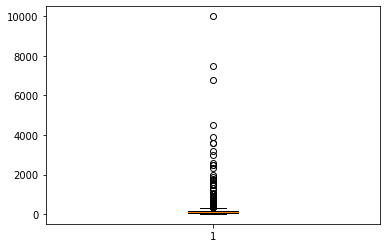

In [8]:
# boxplot of the price values, we see a lot of outliers
plt.boxplot(df_red.price);

In [9]:
# with quantiles
df_red.price.quantile([0.25,0.5,0.75,0.95])

0.25     67.0
0.50    105.0
0.75    175.0
0.95    350.0
Name: price, dtype: float64

In [12]:
# Because it's hard to deal with outliers in ML, we decide to only keep airbnbs with a price less than the 0.95 quantile
# Also, the goal is to find best airbnb, so cheapest.
upper_bound = df_red.price.quantile([0.95]).values[0]
df_red = df_red[df_red.price <= upper_bound]
df_red.shape

(4770, 19)

In [14]:
# standardizing the UTM coordinates
df_red.utm_x = (df_red.utm_x - df_red.utm_x.mean()) / df_red.utm_x.std()
df_red.utm_y = (df_red.utm_y - df_red.utm_y.mean()) / df_red.utm_y.std()
df_coord = df_red[['utm_x', 'utm_y']]

In [15]:
df_coord.head()

,utm_x,utm_y
18907,1.525779,0.321606
46663,0.587161,0.545896
19757,-0.521769,-0.582060
9705,-0.037184,-0.080208
12637,-0.111270,-0.810996


In [16]:
# computing distance between all airbnbs.
from scipy.spatial.distance import squareform, pdist
df_dist = pd.DataFrame(squareform(pdist(df_coord.iloc[:, 0:])), columns=df_coord.index, index=df_coord.index)

In [17]:
df_dist.head()

,18907,46663,19757,9705,12637,19383,35358,28001,7201,12619,...,7233,19220,31563,36874,44418,31193,21368,7460,42535,30115
18907,0.000000,0.965045,2.238094,1.613787,1.990657,1.905653,0.416122,2.186996,1.437458,2.615418,...,1.818962,2.480550,1.528200,1.760461,1.079493,1.636138,0.472098,2.497079,2.328085,5.019624
46663,0.965045,0.000000,1.581774,0.884202,1.526094,1.553706,0.570557,1.725770,1.155485,1.718726,...,1.563938,2.112030,1.018703,1.321656,1.074811,0.751260,1.389383,1.978869,1.476063,4.428261
19757,2.238094,1.581774,0.000000,0.697623,0.470022,0.695116,1.862666,0.478435,0.942458,0.916533,...,0.877145,0.834655,0.719660,0.600408,1.351727,1.802124,2.448420,0.498306,0.620963,2.847888
9705,1.613787,0.884202,0.697623,0.000000,0.734534,0.852281,1.213629,0.911372,0.690753,1.069665,...,0.950008,1.322537,0.367230,0.601007,0.961996,1.199215,1.897849,1.119488,0.743229,3.544452
12637,1.990657,1.526094,0.470022,0.734534,0.000000,0.225114,1.662099,0.203596,0.573080,1.361515,...,0.407704,0.593603,0.511738,0.230477,0.988478,1.933735,2.126394,0.506845,1.037140,3.029048


In [18]:
mean = df_dist.mean().mean()
print('The mean distance is {m}'.format(m=mean))

The mean distance is 1.688530948732736


In [19]:
epsilon = 0.2
sigma = mean * 0.7
def sparsify(x):
    sigm_x = np.exp(- x**2 / (2*sigma**2))
    if sigm_x < epsilon:
        return 0
    return sigm_x

In [20]:
# compute weights of the edges, sparsifying.
df_dist_s = df_dist.applymap(sparsify)
print('there are {i} non-zero entries'.format(i = df_dist_s.astype(bool).sum().sum()))

there are 16538114 non-zero entries


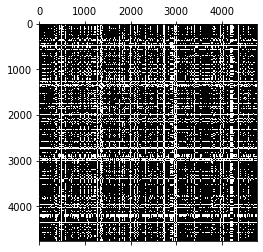

In [21]:
plt.spy(df_dist_s)
plt.show()

In [22]:
# create adjacency matrix, as a numpy array
adj = df_dist_s.values - np.eye(df_dist_s.shape[0])

In [23]:
# DON'T RUN IF NO CONNECTED GRAPH
# check if the graph is connected, and compute the diameter
# epsilon=0.2 and c=0.7 gives connected graph for n=5000 but doesn't work with spectral clustering...
# epsilon=0.5 and c=0.1 gives not connected graph for n=5000 but work with spectral clustering (3 clusters)...
diameter_matrix = np.zeros([len(adj), len(adj)])

# loop until all elements are non-zero
diameter = -1
for i in range(0, 10):
    diameter_matrix += np.linalg.matrix_power(adj, i)
    if diameter_matrix.all() == True:
        diameter = i
        break

print(f"The diameter is: {diameter}")

The diameter is: 6


In [24]:
# dictionnary to rename the labels of the nodes according to their indice in the df
nodes_labels = dict(zip(np.arange(n), df_dist_s.index))

#### Using NetworkX for vizualization (it's faster than pygsp)

In [25]:
# create networkx graph, renaming nodes
import networkx as nx
G = nx.from_numpy_matrix(adj)
G = nx.relabel_nodes(G, nodes_labels)

In [26]:
# create dictionnary for nodes positions (such that the graph is plotted accordinf to NY shape)
coord_dict = df_red.utm.to_dict()

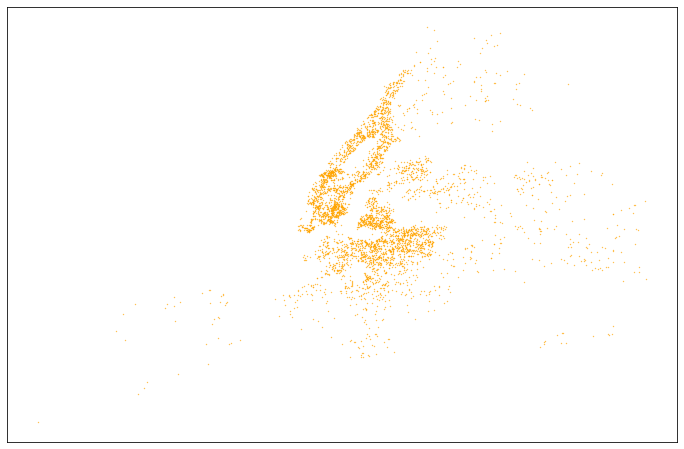

In [28]:
# graph of the airbnb
# take time when lot of edges, set edgelist=[] or remove 'edgelist' parameter to plot edges
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=0.1, node_color='orange', width=0.05, edgelist=[])
plt.show()

In [29]:
# different neighbourhood
df_red.neighbourhood_group.value_counts()

Manhattan        2008
Brooklyn         2007
Queens            605
Bronx             114
Staten Island      36
Name: neighbourhood_group, dtype: int64

In [30]:
# different room types
df_red.room_type.value_counts()

Entire home/apt    2357
Private room       2281
Shared room         132
Name: room_type, dtype: int64

In [31]:
neighbourhoud_to_int = {
    'Manhattan': 1,
    'Brooklyn': 2,
    'Queens': 3,
    'Bronx': 4,
    'Staten Island': 5
}

In [33]:
# transforming neigbourhood names and room types strings into an indice
df_red['neighbourhood_group_indice'] = df_red.neighbourhood_group.apply(lambda x: neighbourhoud_to_int.get(x)).values

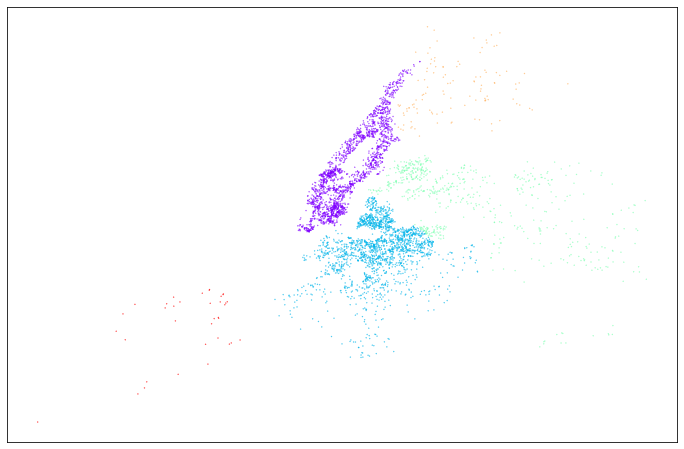

In [34]:
# graph of the airbnb with groundtruth
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=df_red.neighbourhood_group_indice, edgelist=[])
plt.show()

### Using spectral clustering to identify the neighbourhoods

In [35]:
# we keep only the greatest connected component (if graph is not connected)
# not very useful to run spectral clustering on disconnected graph
Gc = max(nx.connected_component_subgraphs(G), key=len)

In [36]:
Gc_nodes = max(nx.connected_components(G), key=len)

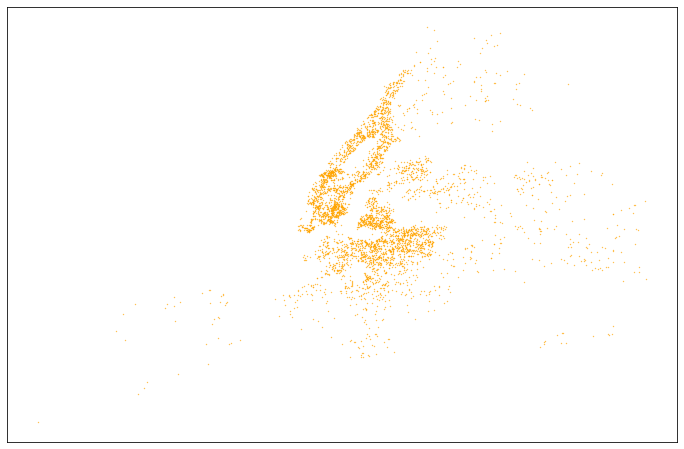

In [37]:
# plotting greatest component
plt.figure(figsize=(12,8))
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, node_color='orange', width=0.05, edgelist=[])
plt.show()

Running spectral clustering on the biggest connected component

In [38]:
# adacency matrix of gc
adj_c = nx.adjacency_matrix(Gc)

In [40]:
# computing labels from spectral clustering
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3, eigen_solver='amg', affinity='precomputed', n_init=100)
sc.fit(adj)

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:286: UserWarning: AMG works better for sparse matrices
  warnings.warn("AMG works better for sparse matrices")
/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pyamg/aggregation/aggregation.py:218: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
                   degree=3, eigen_solver='amg', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=3, n_init=100, n_jobs=None,
                   n_neighbors=10, random_state=None)

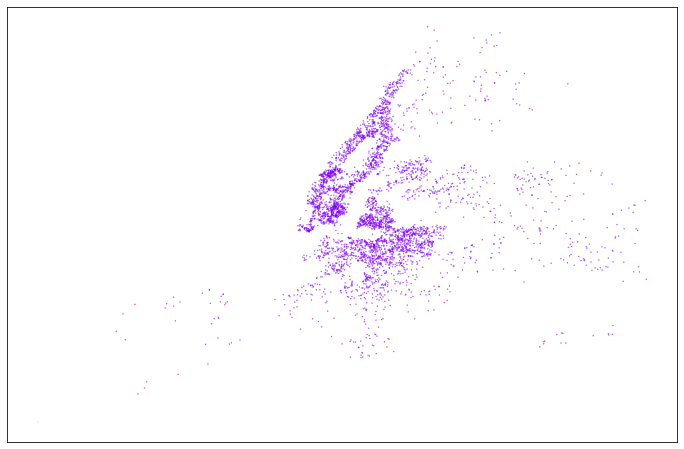

In [41]:
# displaying result of spectrcal clustering
plt.figure(figsize=(12,8))
nx.draw_networkx(Gc, pos=coord_dict, with_labels=False, node_size=0.1, cmap=plt.get_cmap('rainbow'), node_color=sc.labels_, width=0.05, edgelist=[])
plt.show()

### Using PyGSP for graph spectral analysis

In [42]:
from pygsp import graphs, filters, plotting
from pygsp.graphs import Graph

In [43]:
G_gsp = graphs.Graph(adj) # using adj and not adj_c, we need the whole graph
print('{} nodes, {} edges'.format(G_gsp.N, G_gsp.Ne))

4770 nodes, 8266672 edges


In [44]:
G_gsp.is_connected()

True

In [45]:
G_gsp.set_coordinates(kind=np.array(list(coord_dict.values())))

### Computing laplacian 

In [46]:
# computing laplacian of graph
G_gsp.compute_laplacian(lap_type='normalized') # 'combinatorial' or 'normalized'

In [47]:
# computing eigendecomposition of the laplacian
G_gsp.compute_fourier_basis(recompute=True)

2019-12-23 20:39:02,212:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4770 x 4770) may take some time.


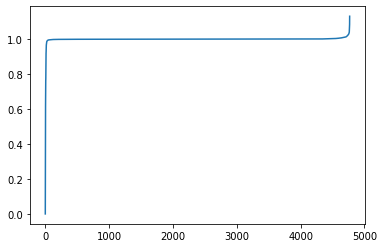

In [48]:
# plot of the eigenvalues
plt.plot(G_gsp.e);

In [49]:
# an eigenvector
eigenevector_index = 0
G_gsp.U[:,eigenevector_index]

array([-0.0106422 , -0.01518656, -0.01646395, ..., -0.0149408 ,
       -0.01647471, -0.00220397])

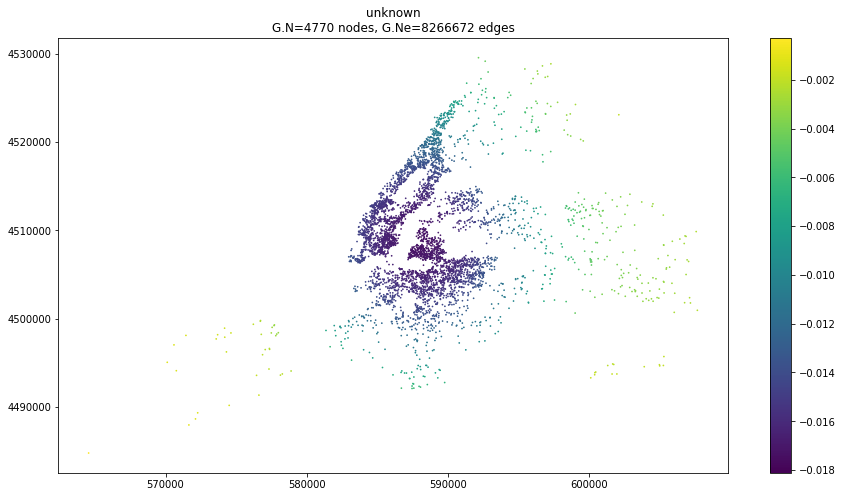

In [50]:
# plot of one of the eigenvector
eigenevector_index = 0
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=G_gsp.U[:, eigenevector_index],vertex_size=0.5,ax=axes)

# WHY FIRST EIGENVECTOR NOT CONSTANT ????

### Prediction of the price

The goal of this section is the predict the price of airbnbs. We will first use Machine Learning techniques, and then spectral filtering to improve the result. We'll use the assumptions that close airbnbs should have close price.

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


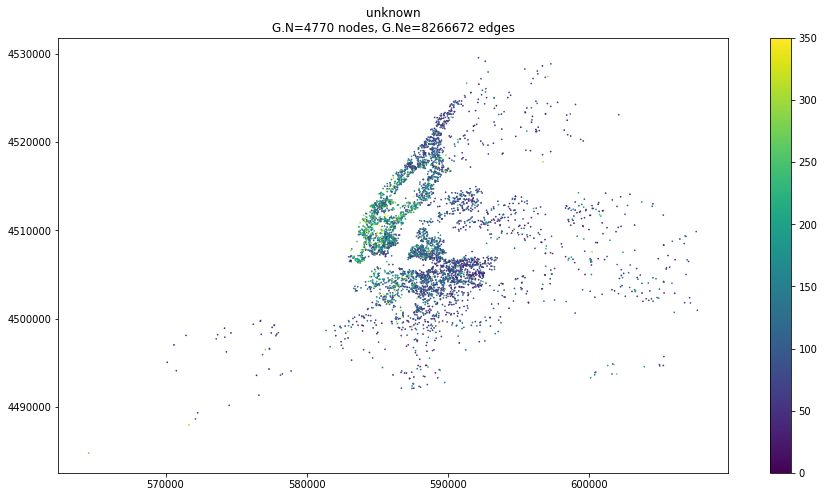

In [51]:
# groundtruth of the price
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=df_red.price,vertex_size=0.5, limits=[0, upper_bound], ax=axes)

In [52]:
shuffled_index = df_red.sample(frac=1).index
reordered_index = df_red.index
df_red.fillna(0, inplace=True) # there are nan values in 'last_review' and 'reviews_per_month' features
df_red.head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,utm,utm_x,utm_y,neighbourhood_group_indice
18907,15019959,Amazing huge furnished room!,445894,Alexa,Queens,Elmhurst,40.74596,-73.87762,Private room,60,2,0,0,0.0,2,66,"(594756.2812514931, 4511162.654725884)",1.525779,0.321606,3


In [53]:
def normalize_serie(x):
    return (x - x.mean())/x.std()

In [54]:
# creating new features for machine learning 
df_red['manhattan'] = (df_red.neighbourhood_group == 'Manhattan').astype(int)
df_red['brooklyn'] = (df_red.neighbourhood_group == 'Brooklyn').astype(int)
df_red['queens'] = (df_red.neighbourhood_group == 'Queens').astype(int)
df_red['bronx'] = (df_red.neighbourhood_group == 'Bronx').astype(int)
df_red['staten_island'] = (df_red.neighbourhood_group == 'Staten Island').astype(int)
df_red['home'] = (df_red.room_type == 'Entire home/apt').astype(int)
df_red['private_room'] = (df_red.room_type == 'Private room').astype(int)
df_red['shared_room'] = (df_red.room_type == 'Shared room').astype(int)

In [133]:
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize, StandardScaler

In [56]:
df_red.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'utm', 'utm_x', 'utm_y',
       'neighbourhood_group_indice', 'manhattan', 'brooklyn', 'queens',
       'bronx', 'staten_island', 'home', 'private_room', 'shared_room'],
      dtype='object')

In [57]:
# suffling the data
df_red.reindex(shuffled_index)

# features when need to predict the price
features_to_augment = df_red[['utm_x', 'utm_y']].values
features_neighbourhood = df_red[['brooklyn', 'queens', 'bronx', 'staten_island']].values
features_basics = df_red[['number_of_reviews', 'reviews_per_month', 'availability_365', 'calculated_host_listings_count', 'home', 'private_room', 'shared_room']].values




In [58]:
# augmenting features
def build_poly(x, degree):
    """build polynomial for ridge regression"""
    nb_features = x.shape[1]
    nb_samples = x.shape[0]
    x_poly = np.ones((nb_samples, 1))
    for d in range(1, degree + 1):
        x_d = x**d
        x_poly = np.hstack((x_poly, x_d))
    return x_poly

In [94]:
features_augmented = build_poly(features_to_augment, 3)
# features = np.hstack((features_augmented, features_neighbourhood, features_basics))
# features = np.hstack((features_neighbourhood, features_basics))
features = features_basics

In [138]:
# building a 5-fold ridge regression
rr = RidgeCV(fit_intercept=False, normalize=False, cv=5, alphas=np.logspace(-5, -1, 20))
rr.fit(X=features, y=df_red.price.values)

RidgeCV(alphas=array([1.00000000e-05, 1.62377674e-05, 2.63665090e-05, 4.28133240e-05,
       6.95192796e-05, 1.12883789e-04, 1.83298071e-04, 2.97635144e-04,
       4.83293024e-04, 7.84759970e-04, 1.27427499e-03, 2.06913808e-03,
       3.35981829e-03, 5.45559478e-03, 8.85866790e-03, 1.43844989e-02,
       2.33572147e-02, 3.79269019e-02, 6.15848211e-02, 1.00000000e-01]),
        cv=5, fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [139]:
# predicting the price 
price_pred_1 = rr.predict(X=features)
price_pred_1

array([ 80.5430443 , 171.1748545 ,  73.43847252, ..., 159.132415  ,
        92.54064937, 169.25514294])

In [140]:
mse_1 = mean_squared_error(y_true=df_red.price.values, y_pred=price_pred_1)
mse_1

3228.4298154676567

In [98]:
df_red['price_pred_1'] = price_pred_1
df_red.reindex(reordered_index).head(1)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,manhattan,brooklyn,queens,bronx,staten_island,home,private_room,shared_room,price_pred_1,price_pred_2
18907,15019959,Amazing huge furnished room!,445894,Alexa,Queens,Elmhurst,40.74596,-73.87762,Private room,60,...,0,0,1,0,0,0,1,0,80.543044,51.201947


/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


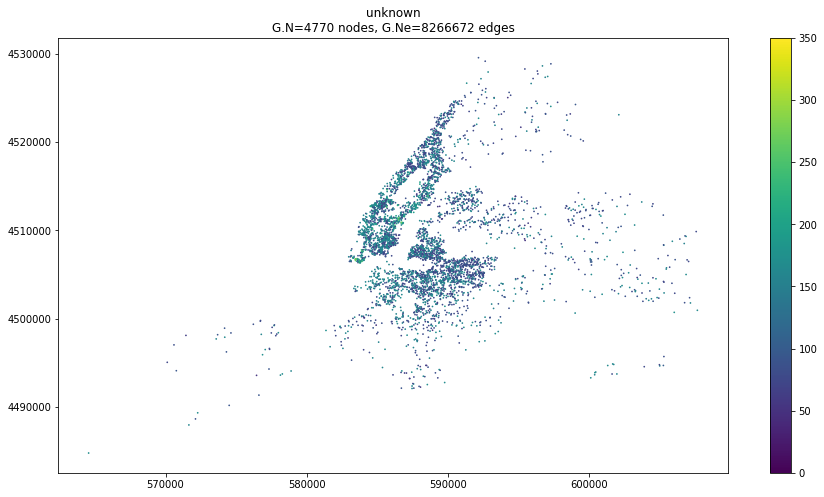

In [99]:
# predicted price using only ML techniques
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=df_red.price_pred_1, vertex_size=0.5, limits=[0, upper_bound], ax=axes)

### Now let's assume that the price is a signal on our graph

In [100]:
def GFT(signal: np.ndarray):
    return G_gsp.U.T @ signal

def iGFT(fourier_coefficients: np.ndarray):
    return G_hsp.U @ fourier_coefficients

[]

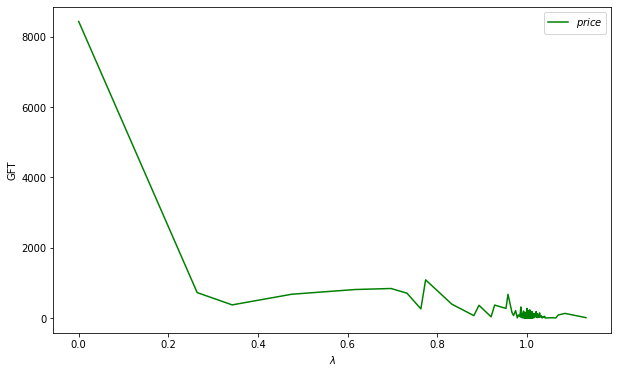

In [101]:
# graph spectrum of the price signal
plt.figure(figsize=(10, 6))
plt.plot(G_gsp.e, np.abs(GFT(df_red.price)), 'g-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$price$', '$x$'])
plt.plot()

[]

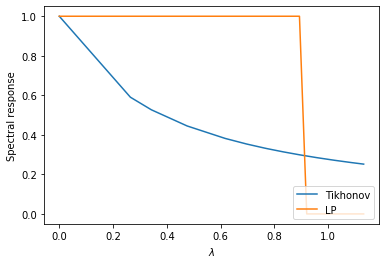

In [102]:
# ideal Tikhonov regularization filter
c = 3
# 6 gives good results for basics_features, 3 for features with neighbourhoods

alpha = 0.99 / (np.max(G_gsp.e) / c)
ideal_tk =  1 / (1 + alpha * G_gsp.e)

# low-pass filter
ideal_lp = np.ones((G_gsp.N,))
threshold = 0.9
ideal_lp[G_gsp.e >= threshold] = 0

plt.plot(G_gsp.e, ideal_tk, '-', label='Tikhonov')
plt.plot(G_gsp.e, ideal_lp, '-', label='LP')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')
plt.plot()

In [103]:
ideal_filter = ideal_tk

In [104]:
# order will be the maximum degree of the polynomial, so there will be order+1 coefficients
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    vdmd = np.vander(np.sort(lam), order+1, increasing=True)
    c, res, rank, s = np.linalg.lstsq(vdmd, spectral_response, rcond=None) # we work in the frequency domain
    return c

In [105]:
def polynomial_graph_filter(coeff: np.array):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    e_values = G_gsp.e
    e_vectors = G_gsp.U
    e_values_filter = polynomial_graph_filter_response(coeff, e_values)
    return e_vectors @ np.diag(e_values_filter) @ e_vectors.T

In [106]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    response = np.zeros(lam.shape[0])
    order = coeff.shape[0]
    for i in range(response.shape[0]): 
        for k in range(order):
            response[i] += coeff[k]*lam[i]**k
    return response

In [107]:
order =  5

coeff = fit_polynomial(G_gsp.e, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff)

Text(0, 0.5, 'Spectral response')

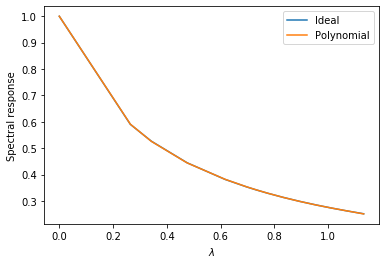

In [108]:
plt.plot(G_gsp.e, ideal_filter)
plt.plot(G_gsp.e, polynomial_graph_filter_response(coeff, G_gsp.e))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

In [109]:
filtered_features = graph_filter @ features
df_red.reindex(shuffled_index);

In [110]:
rr.fit(X=filtered_features, y=df_red.price.values)

RidgeCV(alphas=array([1.00000000e-05, 1.62377674e-05, 2.63665090e-05, 4.28133240e-05,
       6.95192796e-05, 1.12883789e-04, 1.83298071e-04, 2.97635144e-04,
       4.83293024e-04, 7.84759970e-04, 1.27427499e-03, 2.06913808e-03,
       3.35981829e-03, 5.45559478e-03, 8.85866790e-03, 1.43844989e-02,
       2.33572147e-02, 3.79269019e-02, 6.15848211e-02, 1.00000000e-01]),
        cv=5, fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [111]:
# predicting the price 
price_pred_2 = rr.predict(X=filtered_features)

In [112]:
mse_2 = mean_squared_error(y_true=df_red.price.values, y_pred=price_pred_2)
mse_2

2993.117490085566

In [113]:
df_red['price_pred_2'] = price_pred_2
df_red.reindex(reordered_index);

/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/pygsp/plotting.py:482: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
  if np.sum(np.abs(signal.imag)) > 1e-10:


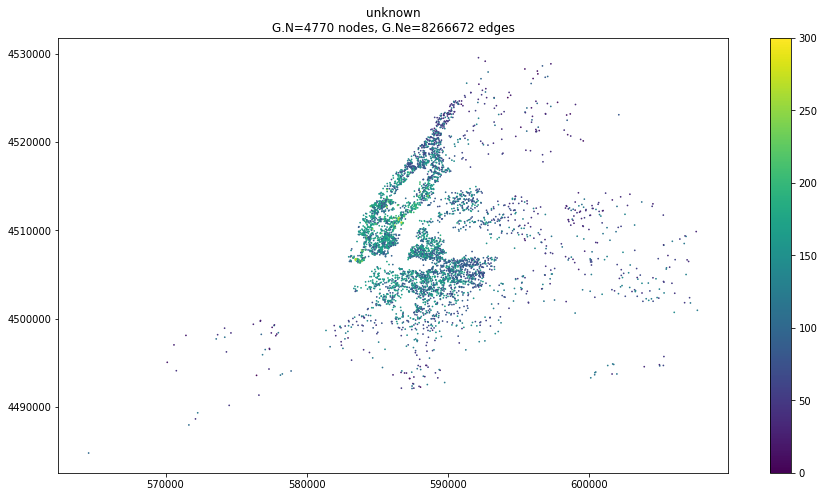

In [114]:
# plot the predicted price - very different from the groundtruth!
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
G_gsp.plot_signal(signal=df_red.price_pred_2, vertex_size=0.5, limits=[0,300], ax=axes)

In [115]:
print('the price are now more accurate of {:.3f} in average'.format(np.sqrt(mse_1 - mse_2)))

the price are now more accurate of 15.340 in average


### Using Neural Netowrks

In [188]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D
import tensorflow as tf

In [192]:
features_size = features.shape[1]

# Neural network
model = Sequential()
model.add(Conv1D(filters=3, kernel_size=2, activation='relu', input_dim=features_size))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 3)           45        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 3)           0         
_________________________________________________________________
dense_50 (Dense)             (None, None, 4)           16        
_________________________________________________________________
dense_51 (Dense)             (None, None, 1)           5         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


/Users/sylvainlugeon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=3, kernel_size=2, activation="relu", input_shape=(None, 7))`
  """


In [185]:
df_red.reindex(shuffled_index)
history = model.fit(filtered_features, df_red.price, epochs=100, batch_size=4)

Epoch 1/100
4770/4770 [==============================] - 2s 339us/step - loss: 4068.5495 - mean_squared_error: 4068.5495
Epoch 2/100
4770/4770 [==============================] - 2s 323us/step - loss: 3957.1459 - mean_squared_error: 3957.1459
Epoch 3/100
4770/4770 [==============================] - 2s 321us/step - loss: 3921.5600 - mean_squared_error: 3921.5600
Epoch 4/100
4770/4770 [==============================] - 2s 317us/step - loss: 3870.2033 - mean_squared_error: 3870.2033
Epoch 5/100
4770/4770 [==============================] - 2s 315us/step - loss: 3824.9603 - mean_squared_error: 3824.9603
Epoch 6/100
4770/4770 [==============================] - 2s 319us/step - loss: 3792.4761 - mean_squared_error: 3792.4761
Epoch 7/100
4770/4770 [==============================] - 2s 316us/step - loss: 3755.1474 - mean_squared_error: 3755.1474
Epoch 8/100
4770/4770 [==============================] - 2s 319us/step - loss: 3713.5147 - mean_squared_error: 3713.5147
Epoch 9/100
4770/4770 [=========

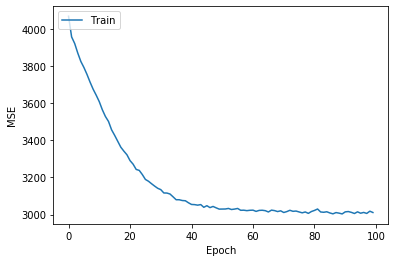

In [186]:
plt.plot(history.history['mean_squared_error'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()